In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import jax
import jax.numpy as jnp
from jax.experimental import host_callback
from tqdm.auto import tqdm
from functools import partial
import frozen_lake
import optuna
import qlearning
import actions
import mangoenv
import utils
import nets

In [2]:
seed = 42
map_scale = 2
map_shape = (2**map_scale, 2**map_scale)
p = 0.5

In [3]:
def train_stage(cell_scale, n_rollouts, rollout_steps, eval_steps, batch_size, rng_key, lower_stage, lr):
    rng_init, rng_steps = jax.random.split(rng_key)
    rng_steps = jax.random.split(rng_steps, n_rollouts)

    reward_fn = partial(actions.reward_fn, cell_scale)
    beta_fn = partial(actions.beta_fn, cell_scale)

    qnet = nets.InnerQnet(lower_stage.action_space.n, map_shape)
    dql_state = qlearning.MultiDQLTrainState.create(
        rng_init, qnet, lower_stage, reward_fn=reward_fn, beta_fn=beta_fn, lr=lr
    )

    pbar = tqdm(range(n_rollouts))

    def sim_step(dql_state, rng_key):
        rng_expl, rng_train, rng_eval = host_callback.id_tap(
            lambda a, t: pbar.update(1), jax.random.split(rng_key, 3)
        )
        transitions = utils.random_rollout(lower_stage, rng_expl, rollout_steps)
        dql_state = dql_state.update_replay(transitions)

        transitions = dql_state.replay_buffer.sample(rng_train, batch_size)
        transitions = dql_state.process_transitions(transitions)
        dql_state = dql_state.update_params(transitions)

        transitions = dql_state.greedy_rollout(lower_stage, rng_eval, eval_steps)
        return dql_state, (transitions.reward, transitions.done)

    dql_state, (rewards, dones) = jax.lax.scan(sim_step, dql_state, rng_steps)
    return dql_state, rewards, dones

# stage 1

In [4]:
cell_scale = 1
max_steps = 1024*128
rollout_steps = 4*4**map_scale
eval_steps = rollout_steps
n_rollouts = max_steps // rollout_steps
batch_size = rollout_steps * 8


rng_env, rng_sim = jax.random.split(jax.random.PRNGKey(seed))
rng_sim = jax.random.split(rng_sim, 16)

env = frozen_lake.FrozenLake.make_random(rng_env, map_scale, p)
abs_env = mangoenv.MangoEnv(env)


parallel_train_stage = jax.jit(
    jax.vmap(
        partial(train_stage, cell_scale, n_rollouts, rollout_steps, eval_steps, batch_size),
        in_axes=(0, None, None),
    )
)


def objective(trial):
    # hyperparams
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    dql_state, rewards, dones = parallel_train_stage(rng_sim, abs_env, lr)
    return rewards.mean()


storage_path = f"sqlite:///optuna_studies/{2**map_scale}x{2**map_scale}/stage_{cell_scale}.db"
study = optuna.create_study(
    study_name=f"mango",
    storage=storage_path,
    load_if_exists=True,
    direction="maximize",
)
study.set_user_attr("rollout_steps", rollout_steps)
study.set_user_attr("eval_steps", eval_steps)
study.set_user_attr("n_rollouts", n_rollouts)
study.set_user_attr("batch_size", batch_size)

study.optimize(objective, n_trials=1, show_progress_bar=True)

[I 2024-02-21 19:19:59,129] Using an existing study with name 'mango' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2048 [00:00<?, ?it/s]

[I 2024-02-21 19:20:58,826] Trial 6 finished with value: 0.008245468139648438 and parameters: {'lr': 0.00021045225525969863}. Best is trial 0 with value: 0.0409088134765625.


In [5]:
study = optuna.load_study(study_name=f"mango", storage=storage_path)

rng_env, rng_sim = jax.random.split(jax.random.PRNGKey(seed))
env = frozen_lake.FrozenLake.make_random(rng_env, map_scale, p)
abs_env = mangoenv.MangoEnv(env)

dql_state, rewards, dones = parallel_train_stage(jax.random.split(rng_sim, 16), abs_env, study.best_params["lr"])
# dql_state, rewards, dones = train_stage(
#     cell_scale, rng_key=rng_sim, lower_stage=env, **study.best_params, **study.user_attrs
# )

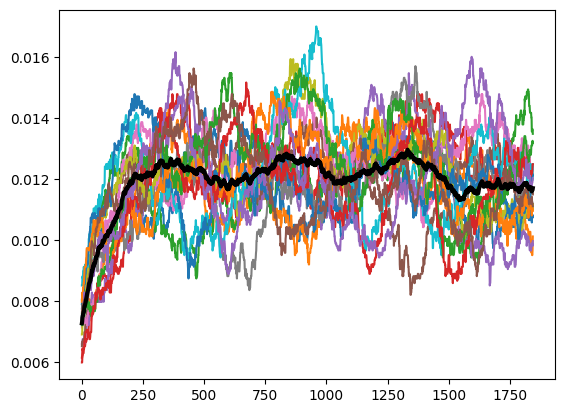

In [ ]:
import matplotlib.pyplot as plt

def smooth(x, w = 0.1):
    w = int(w * len(x))
    return jnp.convolve(x, jnp.ones((w,)) / w, mode='valid')

for rew in rewards:
    plt.plot(smooth(rew.mean(axis=-1)))

plt.plot(smooth(rewards.mean(axis=-1).mean(axis=0)), lw=3, color="black")